In [1]:
import pandas as pd 
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
normal = scipy.io.loadmat('normal_97.mat')
fault = scipy.io.loadmat('fault_7_0_105.mat')

print('Healthy data')
print(normal.keys())
print('\n')
print('Faulty data')
print(fault.keys())

Healthy data
dict_keys(['__header__', '__version__', '__globals__', 'X097_DE_time', 'X097_FE_time', 'X097RPM'])


Faulty data
dict_keys(['__header__', '__version__', '__globals__', 'X105_DE_time', 'X105_FE_time', 'X105_BA_time', 'X105RPM'])


In [3]:
print('Healthy points: ', len(normal['X097_FE_time']))
print('Faulty points: ', len(fault['X105_FE_time']))

Healthy points:  243938
Faulty points:  121265


### Fast visualization

In [4]:
x = np.linspace(0,1,12000)
healthy = normal['X097_FE_time'][0:12000]
faulty = fault['X105_FE_time'][0:12000]

(-1.0, 1.0)

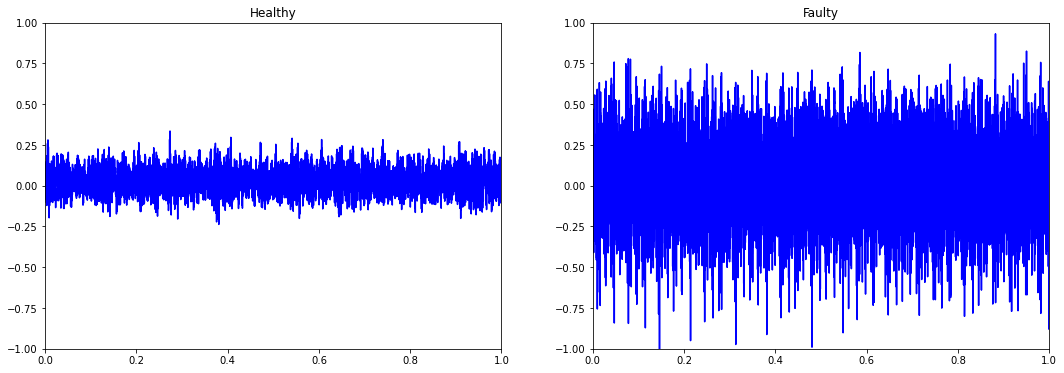

In [5]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.set_title('Healthy')
ax.plot(x, healthy, color='blue')
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])

ax2.set_title('Faulty')
ax2.plot(x, faulty, color='blue')
ax2.set_xlim([0, 1])
ax2.set_ylim([-1, 1])

### Data Analysis

In [1]:
#Determing rolling statistics

#df_data = pd.DataFrame(healthy, columns=['signals'])
#df_data

In [20]:
#rolmean = df_data.rolling(window=52,center=False).mean() 
#rolstd = timeseries.rolling(window=52,center=False).std()

In [2]:
#rolmean

### Trying to generate some feature, for instance: RMS, kurtsosis, crest factor and peak

Petasense calcula estos valores para aceleración, velocidad (en ejes X,Y,Z)

In [6]:
print('RMS calculation')
print('Healthy: ', np.sqrt(np.mean(healthy**2)))
print('Faulty: ', np.sqrt(np.mean(faulty**2)))
print('\n')
print('Kurtosis calculation')
print('Healthy: ', kurtosis(healthy, fisher=False))
print('Faulty: ', kurtosis(faulty, fisher=False))
print('\n')
print('Crest Factor calculation')
print('Healthy: ', np.max(np.abs(healthy))/np.sqrt(np.mean(healthy**2)))
print('Faulty: ', np.max(np.abs(faulty))/np.sqrt(np.mean(faulty**2)))
print('\n')
print('Peak calculation')
print('Healthy: ', np.max(np.abs(healthy)))
print('Faulty: ', np.max(np.abs(faulty)))

RMS calculation
Healthy:  0.08310391662146419
Faulty:  0.24662274662877104


Kurtosis calculation
Healthy:  [2.72162424]
Faulty:  [3.24257474]


Crest Factor calculation
Healthy:  4.037201691172969
Faulty:  4.157030102991237


Peak calculation
Healthy:  0.33550727272727265
Faulty:  1.0252181818181818


### Split data in several intervals (lenght of 1200 points)

In [80]:
# split data in intervals of 12k points:

healthy_splits = np.split(normal['X097_FE_time'][0:240000], 200)
faulty_splits = np.split(fault['X105_FE_time'][0:120000], 100)

print('Healthy "datasets" :', len(healthy_splits))
print('Faulty "datasets" :', len(faulty_splits))

Healthy "datasets" : 200
Faulty "datasets" : 100


### Create a dataframe with features and HEALTH/UNHEALTH

In [81]:
# on healthy data

rms = list(map(lambda i: np.sqrt(np.mean(i**2)), healthy_splits))
crest_factor = list(map(lambda i: np.max(np.abs(i))/np.sqrt(np.mean(i**2)), healthy_splits)) 
peak = list(map(lambda i: np.max(np.abs(i)), healthy_splits))
kurt = list(map(lambda i: kurtosis(i, fisher=False), healthy_splits))

# storing data in data.frame

health_data = {'rms':rms, 
               'crest': crest_factor, 
               'peak': peak, 
               'kurt': kurt, 
               'condition': np.repeat('healthy',len(rms))}  
df_health = pd.DataFrame(health_data)

In [82]:
# on faulty data

rms = list(map(lambda i: np.sqrt(np.mean(i**2)), faulty_splits))
crest_factor = list(map(lambda i: np.max(np.abs(i))/np.sqrt(np.mean(i**2)), faulty_splits)) 
peak = list(map(lambda i: np.max(np.abs(i)), faulty_splits))
kurt = list(map(lambda i: kurtosis(i, fisher=False), faulty_splits))

# storing data in data.frame

faulty_data = {'rms':rms, 
               'crest': crest_factor, 
               'peak': peak, 
               'kurt': kurt, 
               'condition': np.repeat('faulty',len(rms))}  
df_faulty = pd.DataFrame(faulty_data)

In [83]:
# df concatenation
total_data = pd.concat([df_health, df_faulty], axis=0).reset_index(drop=True)

In [84]:
# solving kurtosis format
total_data['kurt'] = total_data['kurt'].explode().astype('float64')

In [86]:
total_data

,rms,crest,peak,kurt,condition
0,0.078861,3.561431,0.280856,2.722576,healthy
1,0.081763,2.902290,0.237300,2.464689,healthy
2,0.086710,3.869307,0.335507,2.885094,healthy
3,0.085167,3.058900,0.260516,2.776591,healthy
4,0.078588,3.775099,0.296676,2.923840,healthy
...,...,...,...,...,...
295,0.243273,3.529341,0.858595,3.203825,faulty
296,0.247586,3.890251,0.963171,3.435007,faulty
297,0.247781,3.831638,0.949405,3.372913,faulty
298,0.249896,3.681630,0.920025,3.311746,faulty


### Generate some visualizations

In [71]:
# General plot function 

def density_plus_box(data, categorical, numerical):
    
    fig = plt.figure(figsize=(14, 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 2, 1)
    sns.kdeplot(x=numerical,data=data, hue=categorical, fill=categorical, ax=ax)
    
    ax = fig.add_subplot(1, 2, 2)
    sns.boxplot(x=categorical, y=numerical, data=data, palette='rainbow', ax=ax)
    plt.xticks(rotation=45)


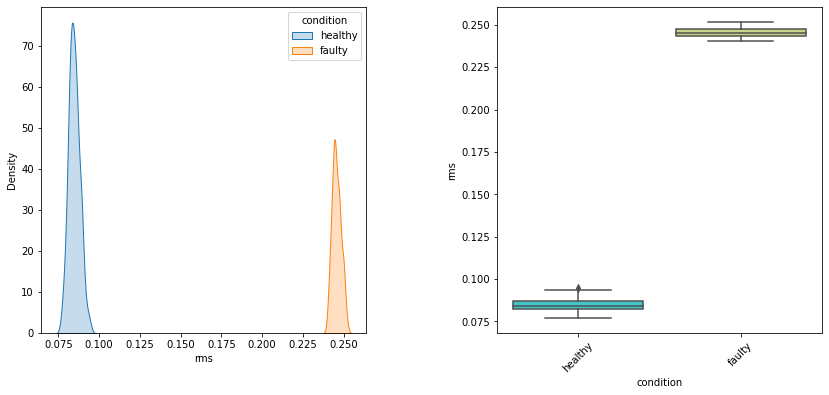

In [88]:
density_plus_box(total_data, 'condition', 'rms')

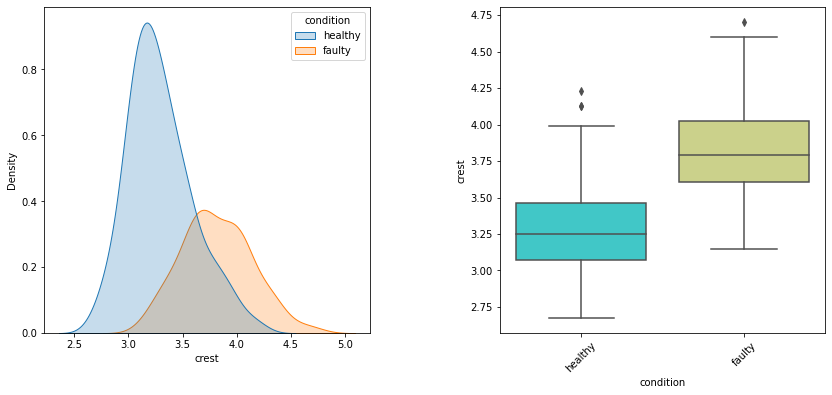

In [45]:
density_plus_box(total_data, 'condition', 'crest')

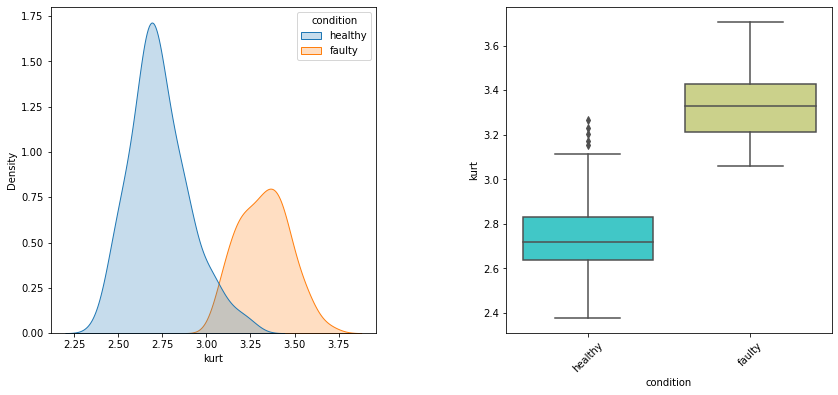

In [89]:
density_plus_box(total_data, 'condition', 'kurt')

<AxesSubplot:>

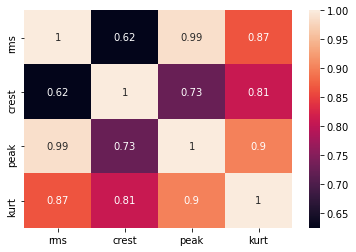

In [90]:
# Correlation 
sns.heatmap(total_data.corr(), annot=True)

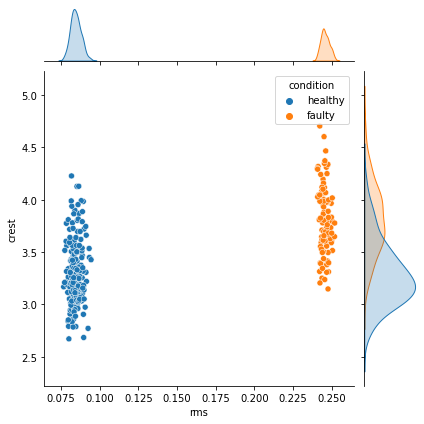

In [44]:
sns.jointplot(x='rms', y='crest', data=total_data, kind='scatter', hue = 'condition')

### Implement a basic ML regression 

#### Feature engineering 

In [93]:
# splitting data

X_train, X_val, y_train, y_val = train_test_split(
    total_data.drop(['condition'], axis=1), 
    total_data['condition'], 
    test_size=0.1,
    random_state=0,
)

X_train.shape, X_val.shape

((270, 4), (30, 4))

In [94]:
X_train.head()

,rms,crest,peak,kurt
92,0.082105,3.175478,0.260722,2.725370
66,0.086895,3.314900,0.288047,2.740750
8,0.076839,3.168510,0.243464,2.506759
122,0.084708,2.789268,0.236273,2.509371
219,0.247579,3.496177,0.865580,3.263975


#### Models

**Logistic regression**

In [97]:
logit = LogisticRegression(random_state=0,  max_iter=1000)
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

**Random Forest**

In [98]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

#### Predictions

In [101]:
print('ROC-AUC Logistic Regression val: {}'.format(roc_auc_score(y_val, logit.predict_proba(X_val)[:,1])))
print('ROC-AUC Random Forest val: {}'.format(roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])))

ROC-AUC Logistic Regression val: 1.0
ROC-AUC Random Forest val: 1.0
